In [3]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pylab import cm as cmaps
from pylab import rcParams
import healpy as hp
from tqdm import *
from astropy import units as u
from scipy.ndimage.filters import gaussian_filter

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from plot_params import params
from simulation.astrometry_sim import QuasarSim
from theory.units import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
from plot_params import params
import matplotlib.pylab as pylab

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

alpha_plot = 1.
lw_plot = 2.5

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsha

In [7]:
# pylab.rcParams.update(params)
# plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/LensPower/Draft/plots/"
# plots_dir = "/Users/smsharma/Desktop/LensPower_Offline/plots/"

# data_dir = "/Users/smsharma/QuasarSims/"

In [3]:
max_sep = 25
nside = 64
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True,
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=False, 
                do_alpha=False,
                sh_profile='NFW')

sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=200., alpha=-1.9)
sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
sim.set_subhalo_properties(sim.c200_SCP, distdep=False)

sim.analysis_pipeline(get_sample=True)

Simulating 1628 subhalos between 7.0 and 10.0


/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds


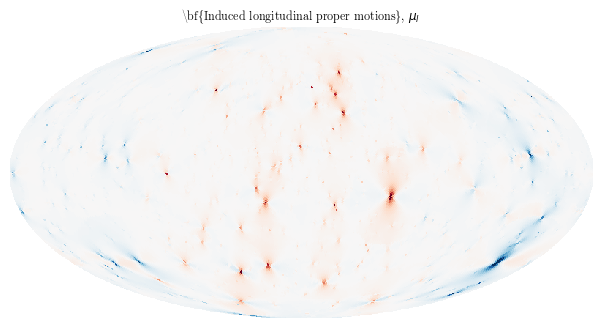

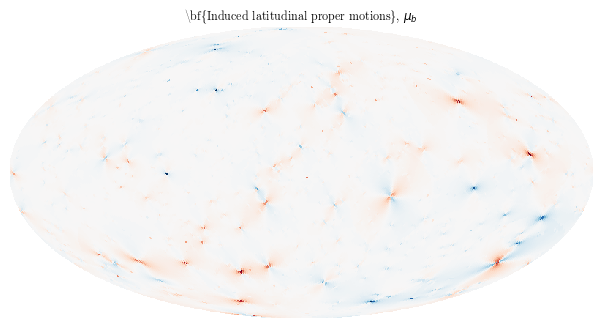

In [7]:
max_mu = 8e-4 / 0.6e-4
cmap = cmaps.RdBu_r
cmap.set_under('w')

hp.mollview(1e6 * sim.mu_qsrs[:,0] / 1e-4,max=max_mu, min=-max_mu, title=r"\bf{Induced longitudinal proper motions}, $\mu_l$", unit='$\mu$as\,yr$^{-1}$', cmap=cmap, cbar=None)
hp.mollview(1e6 * sim.mu_qsrs[:,1] / 1e-4,max=max_mu, min=-max_mu, title=r"\bf{Induced latitudinal proper motions}, $\mu_b$", unit='$\mu$as\,yr$^{-1}$', cmap=cmap, cbar=None)

In [8]:
import sys
sys.path.append("../")

from models.embedding import SphericalGraphCNN

In [9]:
nside_list = [64, 32, 16, 8, 4, 2, 1]

In [262]:
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, mask_ring = False)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])


In [263]:
in_map[0].shape

torch.Size([49152, 2])

In [264]:
import torch
in_map = torch.Tensor((sim.mu_qsrs.reshape((1, -1, 2))))
in_map.shape

torch.Size([1, 49152, 2])

In [265]:
log_mean = torch.log(torch.mean(in_map, axis=1))
log_std = torch.log(torch.var(in_map, axis=1).sqrt())

log_mean = log_mean.reshape((1, -1, 2))
log_std = log_std.reshape((1, -1, 2))

data_map = torch.cat([in_map], axis=1)
data_map.shape

torch.Size([1, 49152, 2])

In [266]:
data_map = data_map.view(-1, 2, 49152)

In [267]:
sg = SphericalGraphCNN(nside_list, indexes_list, in_ch=2)

In [268]:
data_map = torch.cat(4 * [data_map])

In [269]:
data_map.shape

torch.Size([4, 2, 49152])

In [270]:
theta = torch.ones([4, 1000])

In [271]:
sg(data_map, theta).shape

torch.Size([4, 32])

## Analysis

In [9]:
import sys
sys.path.append("../")

from sbi.neural_nets.classifier import build_mlp_mixed_classifier
from sbi import utils
import torch

In [10]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

run_id = '98ecc563d0794e22ae349a98408caa4e'
    
data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-astrometry/data/logs/mlruns/0/' + run_id + '/artifacts/density_estimator')

In [11]:
from tqdm.notebook import tqdm

In [12]:
max_sep = 25
nside = 64
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True,
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=False, 
                do_alpha=False,
                sh_profile='NFW')

sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=150., alpha=-1.9)
sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
sim.set_subhalo_properties(sim.c200_SCP, distdep=False)

Simulating 1208 subhalos between 7.0 and 10.0


In [13]:
n_trials = 20
n_test = 50

out = np.zeros((n_trials, n_test))

for i_trial in tqdm(range(n_trials)):
    
    sim.analysis_pipeline(get_sample=True)
    sim.mu_qsrs = 1e6 * hp.reorder(sim.mu_qsrs.T, r2n=True).T
    
    x_test = sim.mu_qsrs + np.random.normal(loc=0, scale=0.0022 / 1., size=sim.mu_qsrs.shape)
    x_test = torch.Tensor(1 * [x_test.T]).contiguous() 

    theta_test = torch.linspace(0., 300., n_test).unsqueeze(1)

    out[i_trial, :] = [density_estimator(x_test[0].unsqueeze(0), theta_test[i].unsqueeze(0)).squeeze().detach().numpy() \
           for i in (range(n_test))]


  0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
out = np.mean(out, axis=0)

In [15]:
from scipy.stats import chi2
from scipy.stats import norm

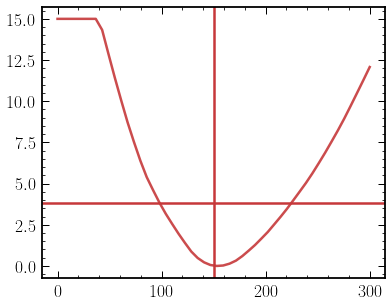

In [16]:
llrmin, llrmax = 0., 15.
llr = - 2 * out
llr -= np.min(llr)
llr = np.clip(llr, llrmin, llrmax)

plt.plot(theta_test.squeeze().detach().numpy(), llr)
plt.axhline(chi2.isf(.05, 1))
plt.axvline(150)

In [18]:
from theory.units import *
from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast

In [19]:
# Precompute some number for NFW and Burkert
pspec = PowerSpectra(precompute=['NFW', 'Burk'])

In [20]:
# Calculate spectra for fiducial CDM

pspecpop = PowerSpectraPopulations(l_max=2000)

pspecpop.set_radial_distribution(pspecpop.r2rho_V_ein_EAQ, R_min=1e-2*kpc, R_max=260*kpc)
pspecpop.set_mass_distribution(pspecpop.rho_M_SI, M_min=1e7*M_s, M_max=1e10*M_s, 
                               M_min_calib=1e8*M_s, M_max_calib=1e10*M_s, N_calib=150, alpha=-1.9)
pspecpop.set_subhalo_properties(pspecpop.c200_SCP)

C_l_mu = pspecpop.get_C_l_total_ary();

  0%|          | 0/50 [00:00<?, ?it/s]

In [701]:
# Test

sigma_mu = .1
sigma_alpha = None
N_q = 1e8

fDM_base = 1
dfDM_base = 0.1

Cl_ary_fid = pspecpop.C_l_ary*fDM_base

p = pspecpop.C_l_ary*(fDM_base + dfDM_base)
m = pspecpop.C_l_ary*(fDM_base - dfDM_base)

fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                None, None, '$\\f_\mathrm{DM}$' )

In [702]:
M_calib_ary = np.logspace(8, 10) * M_s
calib = 150 / np.trapz(pspecpop.rho_M_SI(M_calib_ary, alpha=-1.9), M_calib_ary)

M_ary = np.logspace(-6, 10) * M_s
f_sub_fid = np.trapz(M_ary * calib * pspecpop.rho_M_SI(M_ary, alpha=-1.9), M_ary) / M_MW

In [17]:
signal = np.linspace(1e-3, 2, 100)

ls_list = ['-', '--', '-.']

for i_l, l_min in enumerate([2, 5, 10]):

    parameters = [Cl_ary_fid, None, pspecpop.l_min, pspecpop.l_max, fDM]
    observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=None, N_q_mu=N_q, l_min_mu=l_min, l_max_mu=300, l_min_alpha=2, l_max_alpha=2000)

    fshr = FisherForecast(parameters, observation)

    sigma=fshr.pars_vary[0].sigma

    x_arr=np.linspace(0, 2)
    LL_ary = norm.logpdf(x_arr, fDM_base, sigma)
    plt.plot(f_sub_fid * x_arr, -2 * (LL_ary - np.max(LL_ary)), label=r"PS, $\ell \geq {}$".format(l_min), ls=ls_list[i_l], color=cols_default[1])


llrmin, llrmax = 0., 15.

llr = - 2 * out
llr -= np.min(llr)
llr = np.clip(llr, llrmin, llrmax)

offset = (f_sub_fid - (f_sub_fid / 150) * theta_test.squeeze().detach().numpy()[np.argmin(llr)])
plt.plot(offset + (f_sub_fid / 150) * theta_test.squeeze().detach().numpy(), llr, label="GCNN", color=cols_default[0])


plt.axhline(chi2.isf(1 - .95, 1), color='grey', alpha=0.4, lw=1)
plt.text(f_sub_fid / 3, chi2.isf(1 - .95, 1) + 0.1, r"$2\sigma$",  color='grey', alpha=0.8)

plt.axhline(chi2.isf(1 - .68, 1), color='grey', alpha=0.4, lw=1)
plt.text(f_sub_fid / (3 / 2), chi2.isf(1 - .68, 1) + 0.1, r"$1\sigma$",  color='grey', alpha=0.8)

plt.axvline(f_sub_fid, color='k', lw=1, ls='--')

plt.ylim(-0.5, 12)
plt.xlim(0, 0.4)

plt.legend(loc='upper right', frameon=True, framealpha=0.95)

plt.xlabel(r"$f_\mathrm{sub}$")
plt.ylabel(r"$\mathrm{TS}  = -2 \ln  (\mathcal L / \mathcal L_\mathrm{max}) $")

plt.title(r"\bf{Non-Gaussian astrometric signature}", y=1.01)

NameError: name 'Cl_ary_fid' is not defined

In [1]:
# import healpy as hp
# Sigma_q = 1e8 / (4 * np.pi)
# pixarea = hp.nside2pixarea(nside=64, degrees=False)
# N_q_pix = Sigma_q * pixarea
# sigma_pix = .1 / np.sqrt(N_q_pix)
# sigma_pix

# the_map = np.load("../../sbi-astrometry/data/x_train_49.npy")[4, 0] 
# the_map += np.random.normal(loc=0, scale=sigma_pix, size=the_map.shape)
# hp.mollview(the_map, nest=True, cmap='RdBu_r')